In [129]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import spacy
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

In [2]:
train=pd.read_csv('twitter_training.csv')
test=pd.read_csv('twitter_test.csv')

In [3]:
train.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [4]:
test.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [5]:
train.columns=['id','app','sentiment','text']
test.columns=['id','app','sentiment','text']

In [6]:
train.head()

,id,app,sentiment,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [7]:
test.head()

,id,app,sentiment,text
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74681 non-null  int64 
 1   app        74681 non-null  object
 2   sentiment  74681 non-null  object
 3   text       73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [9]:
cat_cols=train.select_dtypes(include=['object'])
for col in cat_cols:
  print(f"{col}'s unique values: {train[col].unique()}")

app's unique values: ['Borderlands' 'CallOfDutyBlackopsColdWar' 'Amazon' 'Overwatch'
 'Xbox(Xseries)' 'NBA2K' 'Dota2' 'PlayStation5(PS5)' 'WorldOfCraft'
 'CS-GO' 'Google' 'AssassinsCreed' 'ApexLegends' 'LeagueOfLegends'
 'Fortnite' 'Microsoft' 'Hearthstone' 'Battlefield'
 'PlayerUnknownsBattlegrounds(PUBG)' 'Verizon' 'HomeDepot' 'FIFA'
 'RedDeadRedemption(RDR)' 'CallOfDuty' 'TomClancysRainbowSix' 'Facebook'
 'GrandTheftAuto(GTA)' 'MaddenNFL' 'johnson&johnson' 'Cyberpunk2077'
 'TomClancysGhostRecon' 'Nvidia']
sentiment's unique values: ['Positive' 'Neutral' 'Negative' 'Irrelevant']
text's unique values: ['I am coming to the borders and I will kill you all,'
 'im getting on borderlands and i will kill you all,'
 'im coming on borderlands and i will murder you all,' ...
 'Just realized the windows partition of my Mac is now 6 years behind on Nvidia drivers and I have no idea how he didn’t notice'
 'Just realized between the windows partition of my Mac is like being 6 years behind on Nvidi

In [10]:
train.duplicated().sum()

2700

In [11]:
train=train.drop_duplicates()

Text(0, 0.5, 'Count')

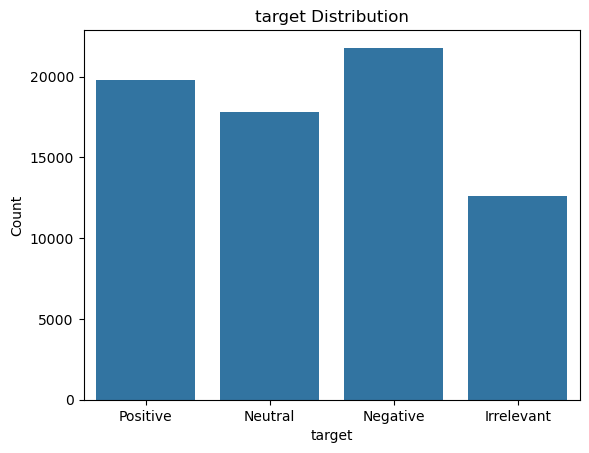

In [12]:
sns.countplot(x='sentiment',data=train)
plt.title("target Distribution")
plt.xlabel("target")
plt.ylabel("Count")

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from nltk.tokenize import word_tokenize

In [14]:
nlp=spacy.load("en_core_web_sm")

In [22]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [64]:
lemmatizer=WordNetLemmatizer()
stop=set(stopwords.words('english'))

In [65]:
def clean_text(text):
    text=str(text).lower().strip()
    if text =='':
        return ''
    
    #remove URLs, mentions, hashtags
    text= re.sub(r'http\S+|www\S+|https\S+', '', text)
    text= re.sub(r'@\w+|#', '', text)
    text= re.sub(r'[^a-z\s]', '', text)
    
    #tokenize
    tokens = word_tokenize(text)
    
    #remove stopwords
    tokens = [word for word in tokens if word not in stop]
    
    #lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

In [68]:
#applying cleaning to training data
print("Cleaning training data")
train['clean_text']=train['text'].apply(clean_text)
train=train[train['clean_text'] != '']

Cleaning training data...


In [69]:
train['clean_text'].info()

<class 'pandas.core.series.Series'>
Index: 70318 entries, 0 to 74680
Series name: clean_text
Non-Null Count  Dtype 
--------------  ----- 
70318 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB


In [70]:
#applying cleaning to test data
test['clean_text'] = test['text'].apply(clean_text)
test=test[test['clean_text'] != '']
test['clean_text'].info()

<class 'pandas.core.series.Series'>
Index: 998 entries, 0 to 998
Series name: clean_text
Non-Null Count  Dtype 
--------------  ----- 
998 non-null    object
dtypes: object(1)
memory usage: 15.6+ KB


In [71]:
text=' '.join(train['clean_text'])

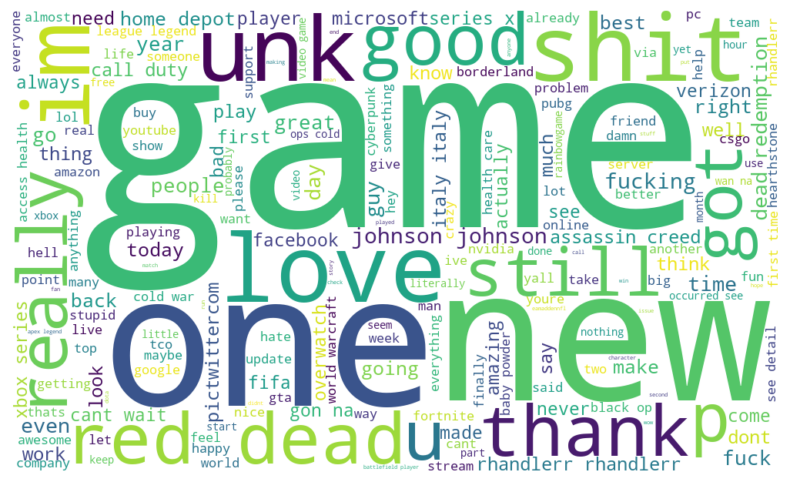

In [72]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=1000, height=600, background_color='white').generate(text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [73]:
#encode labels
label_encoder=LabelEncoder()
y=label_encoder.fit_transform(train['sentiment'])

In [77]:
print("Label mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

Label mapping: {'Irrelevant': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3}


In [78]:
#bag of words
bow_vectorizer = CountVectorizer(max_features=1000)
X_bow = bow_vectorizer.fit_transform(train['clean_text'])

In [79]:
tfidf=TfidfVectorizer(max_features=5000)
X_tfidf=tfidf.fit_transform(train['clean_text'])

In [80]:
X.shape

(71809, 5000)

In [81]:
#split
X_train_bow, X_val_bow, y_train, y_val = train_test_split(X_bow, y, test_size=0.2, random_state=42)
X_train_tfidf, X_val_tfidf, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [57]:
#logistic Regression with TF-IDF
lr_model=LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
lr_pred=lr_model.predict(X_val_tfidf)
lr_accuracy=accuracy_score(y_val, lr_pred)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

Logistic Regression Accuracy: 0.6776


In [58]:
#Random Forest with TF-IDF
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_tfidf, y_train)
rf_pred = rf_model.predict(X_val_tfidf)
rf_accuracy = accuracy_score(y_val, rf_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")


Random Forest Accuracy: 0.8706


In [83]:
#best model for predictions
X_test_tfidf = tfidf.transform(test['clean_text'])
test_predictions = rf_model.predict(X_test_tfidf)
test['predicted_sentiment'] = label_encoder.inverse_transform(test_predictions)
print(test[['text', 'predicted_sentiment']].head())

                                                text predicted_sentiment
0  BBC News - Amazon boss Jeff Bezos rejects clai...             Neutral
1  @Microsoft Why do I pay for WORD when it funct...            Negative
2  CSGO matchmaking is so full of closet hacking,...            Negative
3  Now the President is slapping Americans in the...             Neutral
4  Hi @EAHelp I’ve had Madeleine McCann in my cel...            Negative


# Sequence model (preprocessing and sequence model

In [106]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [107]:
texts=train['clean_text'].tolist()
test_texts=test['clean_text'].tolist()

In [108]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

In [109]:
vocab_size = len(tokenizer.word_index) + 1  #+1 for 0-index padding
print(f"Your actual vocabulary size: {vocab_size}")

Your actual vocabulary size: 34656


In [110]:
sequences=tokenizer.texts_to_sequences(texts)
test_sequences=tokenizer.texts_to_sequences(test_texts)

In [111]:
max_length=100
X_sequences=pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
X_test_sequences=pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

In [112]:
print(f"Padded sequences shape: {X_sequences.shape}")
print(f"Max sequence length: {max_length}")

Padded sequences shape: (70318, 100)
Max sequence length: 100


In [123]:
y_categorical = to_categorical(y)

In [114]:
X_seq_train, X_seq_val, y_seq_train, y_seq_val=train_test_split(X_sequences, y_categorical, test_size=0.2, random_state=42, stratify=y)

In [115]:
print(f"Training sequences: {X_seq_train.shape}")
print(f"Validation sequences: {X_seq_val.shape}")

Training sequences: (56254, 100)
Validation sequences: (14064, 100)


In [125]:
#LSTM model
model=Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [127]:
history = model.fit(X_seq_train, y_seq_train,epochs=5,batch_size=32,validation_data=(X_seq_val, y_seq_val),verbose=1)

Epoch 1/5
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 203s 105ms/step - accuracy: 0.4873 - loss: 1.1588 - val_accuracy: 0.7649 - val_loss: 0.6386
Epoch 2/5
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 262s 149ms/step - accuracy: 0.8307 - loss: 0.5025 - val_accuracy: 0.8338 - val_loss: 0.4791
Epoch 3/5
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 354s 201ms/step - accuracy: 0.9015 - loss: 0.3021 - val_accuracy: 0.8510 - val_loss: 0.4545
Epoch 4/5
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 437s 232ms/step - accuracy: 0.9279 - loss: 0.2124 - val_accuracy: 0.8607 - val_loss: 0.4585
Epoch 5/5
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 372s 211ms/step - accuracy: 0.9409 - loss: 0.1775 - val_accuracy: 0.8591 - val_loss: 0.5007


In [130]:
test_pred = model.predict(X_test_sequences)
test['lstm_predictions'] = label_encoder.inverse_transform(np.argmax(test_pred, axis=1))
print(test[['text', 'lstm_predictions']].head())

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
                                                text lstm_predictions
0  BBC News - Amazon boss Jeff Bezos rejects clai...          Neutral
1  @Microsoft Why do I pay for WORD when it funct...         Negative
2  CSGO matchmaking is so full of closet hacking,...         Negative
3  Now the President is slapping Americans in the...          Neutral
4  Hi @EAHelp I’ve had Madeleine McCann in my cel...         Negative
